In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import time
import psutil
import threading
from memory_profiler import memory_usage

import joblib

# 1. Loading and preparing

In [2]:
df = pd.read_csv('D:/github/nids2/dataset/cleaned/cicids2017_cleaned.csv')

In [3]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'PSH Flag Count',
       'ACK Flag Count', 'Average Packet Size', 'Subflow Fwd Bytes',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_p

## 1.1. Preparing training and testing set using stratified split

In [4]:
# splitting df for training and testing using stratified split
X = df.drop('Attack Type', axis=1) # features
y = df['Attack Type'] # target

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train = strat_train_set.drop("Attack Type", axis=1)
y_train = strat_train_set["Attack Type"]

X_test = strat_test_set.drop("Attack Type", axis=1)
y_test = strat_test_set["Attack Type"]

print(pd.DataFrame({
    "count (df)": df["Attack Type"].value_counts(),
    "count (train_set)": strat_train_set["Attack Type"].value_counts(),
    "count (test_set)": strat_test_set["Attack Type"].value_counts(),
    "proportion": strat_train_set["Attack Type"].value_counts(normalize=True),
})
)

                count (df)  count (train_set)  count (test_set)  proportion
Attack Type                                                                
Normal Traffic     2095057            1676045            419012    0.831124
DoS                 193745             154996             38749    0.076860
DDoS                128014             102411             25603    0.050784
Port Scanning        90694              72555             18139    0.035979
Brute Force           9150               7320              1830    0.003630
Web Attacks           2143               1714               429    0.000850
Bots                  1948               1559               389    0.000773


### Feature scaling

- Feature scaling is important to ensure all features contibute equally to the model's performance, especially for KNN that uses distance metrics. Based on analysis, the dataset contains outliers, hence the most suitable feature scaler is RobustScaler

In [5]:
rbscaler = RobustScaler()

# fit and transform training data, transform testing data
X_train_scaled = rbscaler.fit_transform(X_train)
X_test_scaled = rbscaler.transform(X_test)

### Attack Type resampling for training set

In [6]:
print(pd.DataFrame({
    "count": y_train.value_counts(),
    "proportion": y_train.value_counts(normalize=True)
})
)

                  count  proportion
Attack Type                        
Normal Traffic  1676045    0.831124
DoS              154996    0.076860
DDoS             102411    0.050784
Port Scanning     72555    0.035979
Brute Force        7320    0.003630
Web Attacks        1714    0.000850
Bots               1559    0.000773


- The training dataset shows a considerable imbalance with Normal Traffic as the majority. Hence, Normal Traffic is undersampled to reduce complexity

In [7]:
# Initializing the undersampling for the clean df
X_train_resampled, y_train_resampled = RandomUnderSampler(sampling_strategy={'Normal Traffic': 500000}, random_state=42).fit_resample(X_train, y_train)

# Initializing the undersampling for the scaled df
X_train_scaled, y_train_scaled = RandomUnderSampler(sampling_strategy={'Normal Traffic': 500000}, random_state=42).fit_resample(X_train_scaled, y_train)

In [8]:
print(pd.DataFrame({
    "count": y_train_resampled.value_counts(),
    "proportion": y_train_resampled.value_counts(normalize=True)
})
)

                 count  proportion
Attack Type                       
Normal Traffic  500000    0.594845
DoS             154996    0.184397
DDoS            102411    0.121837
Port Scanning    72555    0.086318
Brute Force       7320    0.008709
Web Attacks       1714    0.002039
Bots              1559    0.001855


- To further balance the training set, Synthetic Minority Over-Sampling (SMOTE) is used to oversample the minority classes

In [9]:
# Initializing the oversampling for the scaled df
X_train_resampled_scaled, y_train_resampled_scaled = SMOTE(sampling_strategy={'Bots': 2000, 'Web Attacks': 2000, 'Brute Force': 7500, 'Port Scanning': 73000, 'DDoS':102500, 'DoS': 200000}, random_state=42).fit_resample(X_train_scaled, y_train_scaled)

In [10]:
print(pd.DataFrame({
    "count": y_train_resampled_scaled.value_counts(),
    "proportion": y_train_resampled_scaled.value_counts(normalize=True)
})
)

del X_train_scaled, X_train, y_train, X, y, df


                 count  proportion
Attack Type                       
Normal Traffic  500000    0.563698
DoS             200000    0.225479
DDoS            102500    0.115558
Port Scanning    73000    0.082300
Brute Force       7500    0.008455
Bots              2000    0.002255
Web Attacks       2000    0.002255


# 2. Machine Learning Training

## 2.1. Random Forest

## 2.1.1. Hyperparameter Tuning

In [16]:
'''
# Defining the parameters for the Random Forest Classifier
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

Creating the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Saving results with the standard parameters
cv_sc_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=3, n_jobs=-1)
cv_sc_rf = np.mean(cv_sc_rf)

# Apply RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=20, cv=3, n_jobs=-1, verbose=2)
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
print(f'Best Parameters: {random_search_rf.best_params_}')
print(f"Best Cross-Validation Score: {random_search_rf.best_score_}")
print(f"Cross-Validation from Standard: {cv_sc_rf}")

best_params_rf = random_search_rf.best_params_ if random_search_rf.best_score_ > cv_sc_rf else None

del random_search_rf
'''

'\n# Defining the parameters for the Random Forest Classifier\nparam_grid = {\n    \'n_estimators\': [100, 150, 200],\n    \'max_depth\': [20, 30, None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'sqrt\', \'log2\'],\n}\n\nCreating the Random Forest Classifier\nrf_model = RandomForestClassifier(random_state=42, n_jobs=-1)\n\n# Saving results with the standard parameters\ncv_sc_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=3, n_jobs=-1)\ncv_sc_rf = np.mean(cv_sc_rf)\n\n# Apply RandomizedSearchCV\nrandom_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=20, cv=3, n_jobs=-1, verbose=2)\nrandom_search_rf.fit(X_train_resampled, y_train_resampled)\n\n# Get the best parameters\nprint(f\'Best Parameters: {random_search_rf.best_params_}\')\nprint(f"Best Cross-Validation Score: {random_search_rf.best_score_}")\nprint(f"Cross-Validation from Standard: {cv_sc_rf}")\n\nbest_

In [17]:
'''
Best Parameters: {'n_estimators': 150, 
                'min_samples_split': 2, 
                'min_samples_leaf': 2, 
                'max_features': 'sqrt', 
                'max_depth': 30}
Best Cross-Validation Score: 0.9986508913753411
Cross-Validation from Standard: 0.998389159543397
'''

"\nBest Parameters: {'n_estimators': 150, \n                'min_samples_split': 2, \n                'min_samples_leaf': 2, \n                'max_features': 'sqrt', \n                'max_depth': 30}\nBest Cross-Validation Score: 0.9986508913753411\nCross-Validation from Standard: 0.998389159543397\n"

## 2.1.2. Model fitting

In [20]:
best_params_rf = {'n_estimators': 150, 
                'min_samples_split': 2, 
                'min_samples_leaf': 2, 
                'max_features': 'sqrt', 
                'max_depth': 30}
cv = 5
n_jobs = -1
random_state = 42

measurement_rf = {}

rf_model = RandomForestClassifier(**best_params_rf, random_state=random_state, n_jobs=n_jobs)

# Function to monitor CPU usage during training
cpu_usage = []
stop_flag = threading.Event()

def monitor_cpu():
    while not stop_flag.is_set():
        cpu_usage.append(psutil.cpu_percent(interval=0.1))

# Function to train the model
def train_model():
    rf_model.fit(X_train_resampled, y_train_resampled)

try:
    # Start CPU monitoring in a separate thread
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()

    # Measure memory usage and training time
    start_time = time.time()
    train_memory_rf = max(memory_usage((train_model,)))  # Measure peak memory usage
    training_time = time.time() - start_time

    # Stop CPU monitoring
    stop_flag.set()
    cpu_thread.join()

    # Add measurements
    measurement_rf['Memory Usage (MB)'] = train_memory_rf
    measurement_rf['Training Time (s)'] = training_time
    measurement_rf['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_rf['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

    # Perform cross-validation
    cv_scores_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=cv, n_jobs=n_jobs)

except Exception as e:
    print(f"Error during Random Forest training: {e}")

## 2.1.3. Model evaluation 

### Cross-validation average score

In [21]:
# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_rf = np.mean(cv_scores_rf)
print(f'Cross validation average score: {cv_scores_mean_rf:.4f} +/- standard deviation: {np.std(cv_scores_rf):.4f}')


Cross validation average score: 0.9987 +/- standard deviation: 0.0001


### Accuracy

In [22]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy on the test set: {accuracy_rf:.4f}')

Accuracy on the test set: 0.9989


### Computational Cost

In [23]:
print("Resource measurements:", measurement_rf)

Resource measurements: {'Memory Usage (MB)': 1579.25390625, 'Training Time (s)': 176.02946305274963, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 97.51254953764861}


### Confusion Matrix

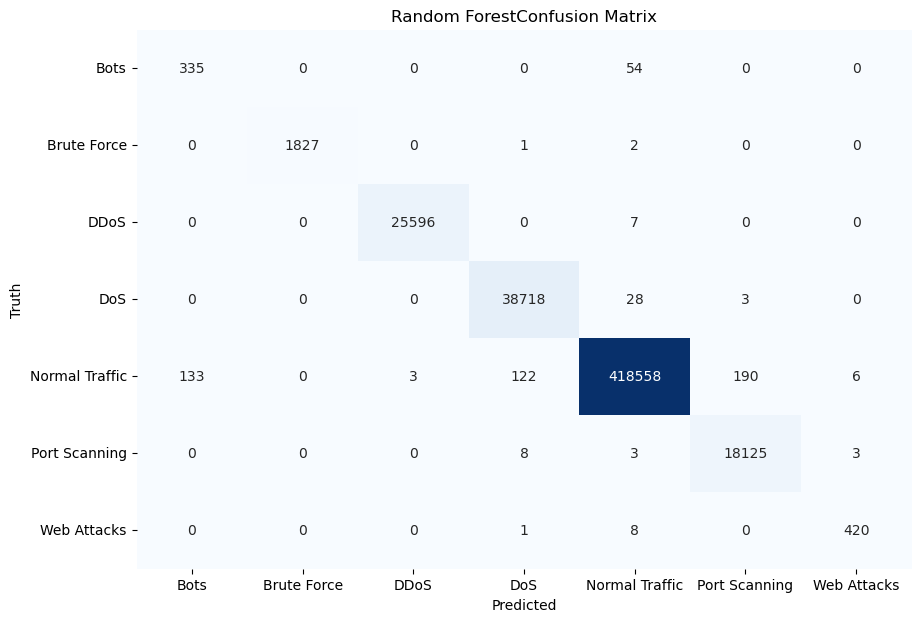

In [25]:
# Evaluating the model via confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Random ForestConfusion Matrix')
plt.show()

### Classification report

In [26]:
print(classification_report(y_test, y_pred_rf))

                precision    recall  f1-score   support

          Bots       0.72      0.86      0.78       389
   Brute Force       1.00      1.00      1.00      1830
          DDoS       1.00      1.00      1.00     25603
           DoS       1.00      1.00      1.00     38749
Normal Traffic       1.00      1.00      1.00    419012
 Port Scanning       0.99      1.00      0.99     18139
   Web Attacks       0.98      0.98      0.98       429

      accuracy                           1.00    504151
     macro avg       0.95      0.98      0.96    504151
  weighted avg       1.00      1.00      1.00    504151



## 2.1.4 Model

In [30]:
joblib.dump(rf_model, 'D:/github/nids3/models/random_forest.joblib')

['D:/github/nids3/models/random_forest.joblib']

## 2.2. XGBoost

### 2.2.1. Hyperparameter Tuning

In [ ]:
'''
# Defining the parameter grid for XGBoost
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.2, 0.3, 0.4],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
}

# XGBoost's `multi:softmax` objective requires numerical labels for classification. Therefore, a mapping is necessary to convert categorical labels into numerical values before training the model.
# # Creating the XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_train_resampled.unique()), random_state=42, n_jobs=-1)

# Custom mapping for the attack types
label_mapping = {
    'Normal Traffic': 0,
    'DoS': 1,
    'DDoS': 2,
    'Port Scanning': 3,
    'Brute Force': 4,
    'Web Attacks': 5,
    'Bots': 6
}
y_train_resampled_mapped = y_train_resampled.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# Saving results with the standard parameters
cv_sc_xgb = cross_val_score(xgb_model, X_train_resampled, y_train_resampled_mapped, cv=3, n_jobs=-1)
cv_sc_xgb = np.mean(cv_sc_xgb)

# Perform RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=30, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search_xgb.fit(X_train_resampled, y_train_resampled_mapped)

# Best parameters found by RandomizedSearchCV
print(f'Best Parameters for XGBoost: {random_search_xgb.best_params_}')
print(f"Best Cross-Validation Score: {random_search_xgb.best_score_}")
print(f"Cross-Validation from Standard: {cv_sc_xgb}")

best_params_xgb = random_search_xgb.best_params_ if random_search_xgb.best_score_ > cv_sc_xgb else None

del random_search_xgb

'''

In [ ]:
'''
Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best Cross-Validation Score: 0.9990827488980495
Cross-Validation from Standard: 0.9990851282783
'''

In [ ]:
## Custom mapping 

In [ ]:
# # Creating the XGBoost Classifier
# xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_train_resampled.unique()), random_state=42, n_jobs=-1)

# Custom mapping for the attack types
label_mapping = {
    'Normal Traffic': 0,
    'DoS': 1,
    'DDoS': 2,
    'Port Scanning': 3,
    'Brute Force': 4,
    'Web Attacks': 5,
    'Bots': 6
}
y_train_resampled_mapped = y_train_resampled.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

## 2.2.2. Model Fitting

In [43]:
best_params_xgb = {'subsample': 1.0, 
				'n_estimators': 100, 
				'min_child_weight': 1, 
				'max_depth': 6, 
				'learning_rate': 0.2, 
				'colsample_bytree': 1.0}
cv = 5
n_jobs = -1
random_state = 42

measurement_xgb = {}

xgb_model = xgb.XGBClassifier(**best_params_xgb, 
							objective='multi:softmax', 
							num_class=len(y_train_resampled_mapped.unique()), 
							random_state = random_state, 
							n_jobs = n_jobs)

# Function to monitor CPU usage during training
cpu_usage = []
stop_flag = threading.Event()

def monitor_cpu():
    while not stop_flag.is_set():
        cpu_usage.append(psutil.cpu_percent(interval=0.1))

# Function to train the model
def train_model():
    xgb_model.fit(X_train_resampled, y_train_resampled_mapped)

try:
    # Start CPU monitoring in a separate thread
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()

    # Measure memory usage and training time
    start_time = time.time()
    train_memory_xgb = max(memory_usage((train_model,)))  # Measure peak memory usage
    training_time = time.time() - start_time

    # Stop CPU monitoring
    stop_flag.set()
    cpu_thread.join()

    # Add measurements
    measurement_xgb['Memory Usage (MB)'] = train_memory_rf
    measurement_xgb['Training Time (s)'] = training_time
    measurement_xgb['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_xgb['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

    # Perform cross-validation
    cv_scores_xgb = cross_val_score(xgb_model, X_train_resampled, y_train_resampled_mapped, cv = cv, n_jobs = n_jobs)

except Exception as e:
    print(f"Error during Random Forest training: {e}")

## 2.2.3. Model Evaluation

### Cross-Validation

In [44]:
# Making predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_xgb = np.mean(cv_scores_xgb)
print(f'Cross validation average score: {cv_scores_mean_xgb:.4f} +/- standard deviation: {np.std(cv_scores_xgb):.4f}')

Cross validation average score: 0.9991 +/- standard deviation: 0.0001


### Accuracy

In [45]:
accuracy_xgb = accuracy_score(y_test_mapped, y_pred_xgb)
print(f'Accuracy on the test set: {accuracy_xgb:.4f}')

Accuracy on the test set: 0.9990


### Computational Cost

In [46]:
print("Resource measurements:", measurement_xgb)

Resource measurements: {'Memory Usage (MB)': 1579.25390625, 'Training Time (s)': 44.26858425140381, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 97.86787439613528}


### Confusion Matrix

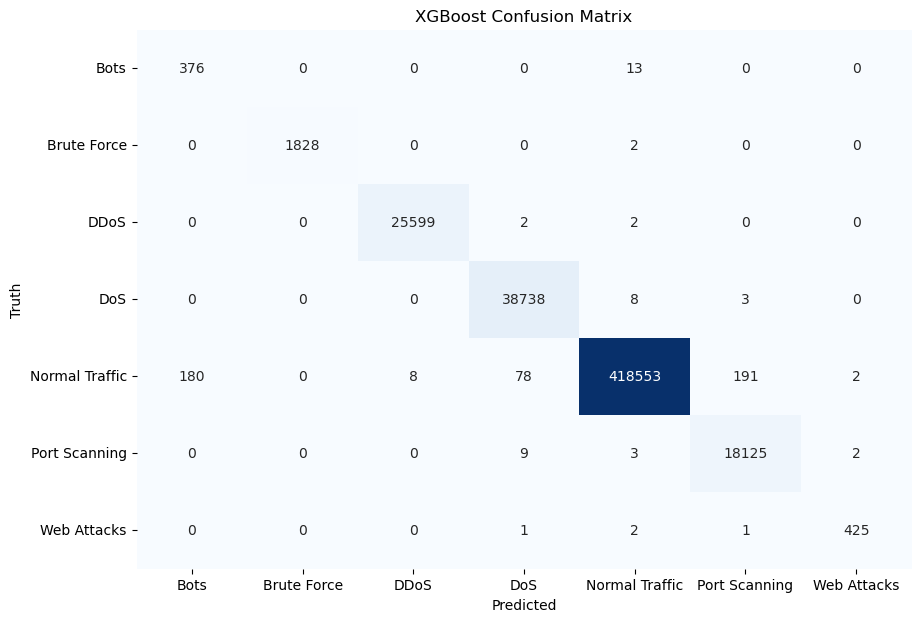

In [49]:
# Remapping the labels for visualization
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
predicted_labels = [reverse_label_mapping[pred] for pred in y_pred_xgb]
actual_labels = sorted([reverse_label_mapping[label] for label in xgb_model.classes_])

# Confusion matrix
cm_xgb = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt='d', xticklabels=actual_labels, yticklabels=actual_labels, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('XGBoost Confusion Matrix')
plt.show()

### Classification Report

In [51]:
print(classification_report(y_test, predicted_labels))

                precision    recall  f1-score   support

          Bots       0.68      0.97      0.80       389
   Brute Force       1.00      1.00      1.00      1830
          DDoS       1.00      1.00      1.00     25603
           DoS       1.00      1.00      1.00     38749
Normal Traffic       1.00      1.00      1.00    419012
 Port Scanning       0.99      1.00      0.99     18139
   Web Attacks       0.99      0.99      0.99       429

      accuracy                           1.00    504151
     macro avg       0.95      0.99      0.97    504151
  weighted avg       1.00      1.00      1.00    504151



### 2.2.3. Exporting model

In [53]:
joblib.dump(rf_model, 'D:/github/nids3/models/xgb.joblib')

['D:/github/nids3/models/xgb.joblib']

## 2.3. K-Nearest Neighbour (KNN)

### 2.3.1. Hyperparameter Tuning

In [47]:
'''
# Defining the parameters for KNN
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
}

# Creating the KNN model
knn_model = KNeighborsClassifier(n_jobs=-1)

# Saving results with the standard parameters
cv_sc_knn = cross_val_score(knn_model, X_train_resampled_scaled, y_train_resampled_scaled, cv=3, n_jobs=-1)
cv_sc_knn = np.mean(cv_sc_knn)

# Apply RandomizedSearchCV
random_search_knn = RandomizedSearchCV(estimator=knn_model, param_distributions=param_grid_knn, n_iter=6, cv=3, n_jobs=-1, verbose=2)
random_search_knn.fit(X_train_resampled_scaled, y_train_resampled_scaled)

# Get the best parameters
print(f'Best Parameters: {random_search_knn.best_params_}')
print(f"Best Cross-Validation Score: {random_search_knn.best_score_}")
print(f"Cross-Validation from Standard: {cv_sc_knn}")

best_params_knn = random_search_knn.best_params_ if random_search_knn.best_score_ > cv_sc_knn else None

del random_search_knn

'''

In [ ]:
# best_params_knn = {'weights': 'distance', 'n_neighbors': 3}

## 2.3.2 Model Fitting

In [ ]:
best_params_knn = {'weights': 'distance', 'n_neighbors': 3}

cv = 5
n_jobs = -1 # use all available processors to run neighbours search
random_state = 42

measurement_knn = {}

knn_model = KNeighborsClassifier(**best_params_knn, n_jobs = n_jobs)

# Function to monitor CPU usage during training
cpu_usage = []
stop_flag = threading.Event()

def monitor_cpu():
    while not stop_flag.is_set():
        cpu_usage.append(psutil.cpu_percent(interval=0.1))

# Function to train the model
def train_model():
    knn_model.fit(X_train_resampled_scaled, y_train_resampled_scaled)

try:
    # Start CPU monitoring in a separate thread
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()

    # Measure memory usage and training time
    start_time = time.time()
    train_memory_knn = max(memory_usage((train_model,)))  # Measure peak memory usage
    training_time = time.time() - start_time

    # Stop CPU monitoring
    stop_flag.set()
    cpu_thread.join()

    # Add measurements
    measurement_knn['Memory Usage (MB)'] = train_memory_knn
    measurement_knn['Training Time (s)'] = training_time
    measurement_knn['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_knn['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

    # Perform cross-validation
    cv_scores_knn = cross_val_score(knn_model, X_train_resampled_scaled, y_train_resampled_scaled, cv = cv, n_jobs = n_jobs)

except Exception as e:
    print(f"Error during Random Forest training: {e}")

## 2.2.3. Model Evalution

### Cross-Validation

In [57]:
y_pred_knn = knn_model.predict(X_test_scaled)
# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_knn = np.mean(cv_scores_knn)
print(f'Cross validation average score: {cv_scores_mean_knn:.4f} +/- standard deviation: {np.std(cv_scores_knn):.4f}')

Cross validation average score: 0.9878 +/- standard deviation: 0.0005


### Accuracy 

In [58]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy on the test set: {accuracy_knn:.4f}')

Accuracy on the test set: 0.9890


### Computational cost

In [59]:
print("Resource measurements:", measurement_knn)

Resource measurements: {'Memory Usage (MB)': 664.4453125, 'Training Time (s)': 2.8372507095336914, 'Peak CPU Usage (%)': 36.8, 'Average CPU Usage (%)': 23.9}


### Confusion matrix

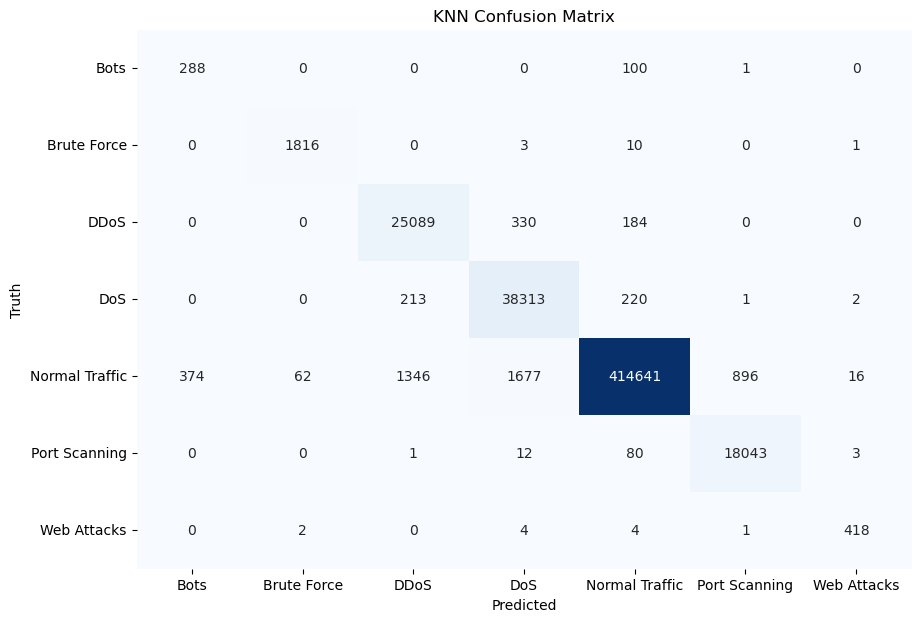

In [60]:
# Evaluating the model via confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('KNN Confusion Matrix')
plt.show()

### Classification Report

In [61]:
# Classification report
print(classification_report(y_test, y_pred_knn))

                precision    recall  f1-score   support

          Bots       0.44      0.74      0.55       389
   Brute Force       0.97      0.99      0.98      1830
          DDoS       0.94      0.98      0.96     25603
           DoS       0.95      0.99      0.97     38749
Normal Traffic       1.00      0.99      0.99    419012
 Port Scanning       0.95      0.99      0.97     18139
   Web Attacks       0.95      0.97      0.96       429

      accuracy                           0.99    504151
     macro avg       0.88      0.95      0.91    504151
  weighted avg       0.99      0.99      0.99    504151



## 2.3.3. Exporting model

In [63]:
joblib.dump(rf_model, 'D:/github/nids3/models/knn.joblib')

['D:/github/nids3/models/knn.joblib']

# 3. Model Comparisons

In [64]:
# Calculating precision, recall, and F1 score for each model
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

precision_xgb = precision_score(y_test_mapped, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test_mapped, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test_mapped, y_pred_xgb, average='weighted')

precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

In [65]:
# Creating the results dataframe
supervised_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'KNN'],
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_knn],
    'Cross Validation Mean': [cv_scores_mean_rf, cv_scores_mean_xgb, cv_scores_mean_knn],
    'Precision': [precision_rf, precision_xgb, precision_knn],
    'Recall': [recall_rf, recall_xgb, recall_knn],
    'F1 Score': [f1_rf, f1_xgb, f1_knn],
    'Memory Usage (MB)': [measurement_rf['Memory Usage (MB)'], measurement_xgb['Memory Usage (MB)'], measurement_knn['Memory Usage (MB)']],
    'Training Time (s)': [measurement_rf['Training Time (s)'], measurement_xgb['Training Time (s)'], measurement_knn['Training Time (s)']],
    'Peak CPU Usage (%)': [measurement_rf['Peak CPU Usage (%)'], measurement_xgb['Peak CPU Usage (%)'], measurement_knn['Peak CPU Usage (%)']],
    'Average CPU Usage (%)': [measurement_rf['Average CPU Usage (%)'], measurement_xgb['Average CPU Usage (%)'], measurement_knn['Average CPU Usage (%)']],
})

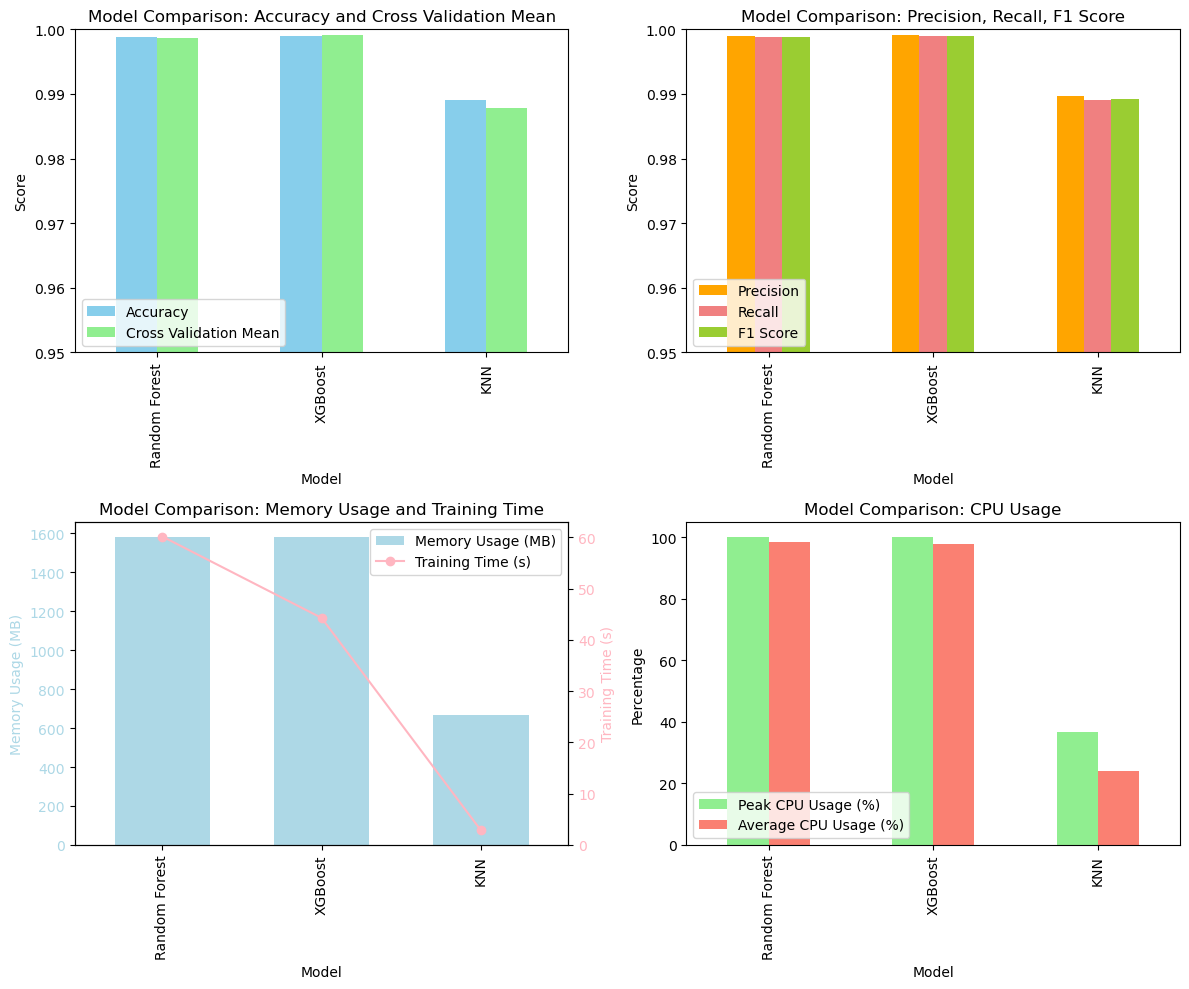

In [66]:
# Plotting the comparison for accuracy, cross-validation, and metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting Accuracy and Cross Validation Mean
supervised_results.set_index('Model')[['Accuracy', 'Cross Validation Mean']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightgreen'], legend=True)
axes[0, 0].set_title('Model Comparison: Accuracy and Cross Validation Mean')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylim(0.95, 1.0)
axes[0, 0].legend(loc='lower left')

# Plotting Precision, Recall, F1 Score
supervised_results.set_index('Model')[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=axes[0, 1], color=['orange', 'lightcoral', 'yellowgreen'], legend=True)
axes[0, 1].set_title('Model Comparison: Precision, Recall, F1 Score')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylim(0.95, 1.0)
axes[0, 1].legend(loc='lower left')

# Plotting Memory Usage and Training Time
ax1 = axes[1, 0]

supervised_results.set_index('Model')['Memory Usage (MB)'].plot(
    kind='bar', ax=ax1, color='lightblue', label='Memory Usage (MB)', width=0.6
)
ax1.set_ylabel('Memory Usage (MB)', color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')

ax2 = ax1.twinx() 
supervised_results.set_index('Model')['Training Time (s)'].plot(
    ax=ax2, color='lightpink', marker='o', label='Training Time (s)'
)
ax2.set_ylabel('Training Time (s)', color='lightpink')
ax2.tick_params(axis='y', labelcolor='lightpink')

ax1.set_title('Model Comparison: Memory Usage and Training Time')
ax1.set_xlabel('Model')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Plotting Peak and Average CPU Usage
supervised_results.set_index('Model')[['Peak CPU Usage (%)', 'Average CPU Usage (%)']].plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'salmon'], legend=True)
axes[1, 1].set_title('Model Comparison: CPU Usage')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_xlabel('Model')
axes[1, 1].legend(loc='lower left')

plt.tight_layout()
plt.show()